**Table of contents**<a id='toc0_'></a>    
- [Mobile Robot line trace](#toc1_)    
- [Starting pybullet](#toc2_)    
- [Initial Setup](#toc3_)    
- [Running the Simulation](#toc4_)    
- [Appendix: Generating Images for Line Tracing](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Mobile Robot line trace](#toc0_)

This notebook simulates line tracing using the bottom camera of a two-wheeled mobile robot.

(For a manual summarizing the functions available in pybullet, please refer to [this link](https://github.com/bulletphysics/bullet3/blob/master/docs/pybullet_quickstartguide.pdf).)

# <a id='toc2_'></a>[Starting pybullet](#toc0_)


Starting pybullet.

In [ ]:
import time
import math
import pybullet
import pybullet_data
physics_client = pybullet.connect(pybullet.GUI) 

pybullet build time: Oct 23 2025 19:25:36


startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=Mesa
GL_RENDERER=llvmpipe (LLVM 20.1.2, 256 bits)
GL_VERSION=4.5 (Core Profile) Mesa 25.0.7-0ubuntu0.24.04.2
GL_SHADING_LANGUAGE_VERSION=4.50
pthread_getconcurrency()=0
Version = 4.5 (Core Profile) Mesa 25.0.7-0ubuntu0.24.04.2
Vendor = Mesa
Renderer = llvmpipe (LLVM 20.1.2, 256 bits)
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started


ven = Mesa
ven = Mesa


# <a id='toc3_'></a>[Initial Setup](#toc0_)

We will perform initial setup such as creating the floor, generating box objects, creating the robot, and setting the camera position.

The line tracing course is generated by loading an image for line tracing with the `loadTexture` function and applying it to the floor using the `changeVisualShape` function.

Therefore, by changing the image specified as an argument to the `loadTexture` function, you can change the line tracing course. (For generating images for line tracing, please refer to "[Appendix: Generating Images for Line Tracing](#toc3_)".)

In [2]:
pybullet.resetSimulation() # Reset the simulation space
pybullet.setAdditionalSearchPath(pybullet_data.getDataPath()) # Add path to necessary data for pybullet
pybullet.setGravity(0.0, 0.0, -9.8) # Set gravity as on Earth
time_step = 1./240.
pybullet.setTimeStep(time_step)

# Load the floor
plane_id = pybullet.loadURDF("plane.urdf", basePosition=[8.0, 4.5, 0.0], globalScaling=5.0)
tex_uid = pybullet.loadTexture("../texture/line_trace_ground.png")
pybullet.changeVisualShape(plane_id, -1, textureUniqueId=tex_uid)

# Load the robot
car_start_pos = [0.0, 0.0, 0.1]  # Set the initial position (x, y, z)
car_start_orientation = pybullet.getQuaternionFromEuler([0, 0, 0])  # Set the initial orientation (roll, pitch, yaw)
car_id = pybullet.loadURDF("../urdf/simple_two_wheel_car.urdf", car_start_pos, car_start_orientation)

# Set the camera position and other parameters in GUI mode
camera_distance = 6.0
camera_yaw = 0.0 # deg
camera_pitch = -90.1 # deg
camera_target_position = [2.5, 0.0, 0.0]
pybullet.resetDebugVisualizerCamera(camera_distance, camera_yaw, camera_pitch, camera_target_position)

# <a id='toc4_'></a>[Running the Simulation](#toc0_)

In the simulation, line tracing is performed using the following steps:

1. Capture the image of the line from the bottom camera
2. Determine the centroid of the line through image processing
3. Adjust the speed of both wheels of the robot using P control based on the position of the centroid
   - Specifically, the greater the difference between the "image center position (x direction)" and the "centroid position of the line (x direction)", the more the robot will turn left or right by adjusting the speed.

In [3]:
import numpy as np

In [4]:
# Define rotation matrices used to calculate the cameraUpVector according to the movement of the mobile robot
def Rx(theta):
    return np.array([[1, 0, 0],
                     [0, np.cos(theta), -np.sin(theta)],
                     [0, np.sin(theta), np.cos(theta)]])

def Ry(theta):
    return np.array([[np.cos(theta), 0, np.sin(theta)],
                     [0, 1, 0],
                     [-np.sin(theta), 0, np.cos(theta)]])

def Rz(theta):
    return np.array([[np.cos(theta), -np.sin(theta), 0],
                     [np.sin(theta), np.cos(theta), 0],
                     [0, 0, 1]])

In [ ]:
import numpy as np
import cv2

# Set the robot to the initial position
car_start_pos = [0.0, 0, 0.1]
car_start_orientation = pybullet.getQuaternionFromEuler([0.0, 0.0, -math.pi/2])
pybullet.resetBasePositionAndOrientation(car_id, car_start_pos, car_start_orientation)

# Set the time length
time_length = 10000

# Bottom camera settings
projection_matrix = pybullet.computeProjectionMatrixFOV(fov=140.0, aspect=1.0, nearVal=0.04, farVal=100)
    
# Link indices
CAMERA_IDX = 8
CAMERA_TARGET_IDX = 9

# Joint indices
RIGHT_WHEEL_JOINT_IDX = 0
LEFT_WHEEL_JOINT_IDX = 1

# P control parameter
Kp = 0.1

# Base speed of the wheels
base_speed = 30

# Default direction of the camera_up_vector
camera_up_vector = np.array([0, -1, 0])

for t in range(time_length):
    # 1. Capture the image of the line from the bottom camera sensor ##########################################################
    # Get the position of the camera link
    camera_link_pose = pybullet.getLinkState(car_id, CAMERA_IDX)[0]

    # Get the position of the virtual link for the target point
    camera_target_link_pose = pybullet.getLinkState(car_id, CAMERA_TARGET_IDX)[0] 

    # Rotate the cameraUpVector according to the posture of the mobile robot
    mobile_robot_roll, mobile_robot_pitch, mobile_robot_yaw = pybullet.getEulerFromQuaternion(pybullet.getLinkState(car_id, CAMERA_IDX)[1])
    R = Rz(np.deg2rad(90.0) + mobile_robot_yaw) @ Ry(mobile_robot_pitch) @ Rx(mobile_robot_roll)
    rotate_camera_up_vector = R @ camera_up_vector

    # Get the viewMatrix from the camera link to the virtual link for the target point
    view_matrix = pybullet.computeViewMatrix(cameraEyePosition=[camera_link_pose[0], camera_link_pose[1], camera_link_pose[2]], 
                                             cameraTargetPosition=[camera_target_link_pose[0], camera_target_link_pose[1], camera_target_link_pose[2]], 
                                             cameraUpVector=[rotate_camera_up_vector[0], rotate_camera_up_vector[1], rotate_camera_up_vector[2]])

    # Capture the image of the line
    # By specifying renderer=pybullet.ER_BULLET_HARDWARE_OPENGL, the image can be captured faster at the expense of quality
    width, height, rgb_img, depth_img, seg_img = pybullet.getCameraImage(600, 300, view_matrix, projection_matrix, renderer=pybullet.ER_BULLET_HARDWARE_OPENGL)
    ############################################################################################################

    # 2. Image processing (calculate the centroid position of the line) ########################################################################
    # Binarize the image
    # img = np.reshape(rgb_img, (height, width, 4))  # Convert the captured image to a 4-channel numpy array
    img = np.array(rgb_img, dtype=np.uint8).reshape(height, width, 4) # Convert the captured image to a 4-channel numpy array
    img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)  # Convert from RGBA to RGB
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # Convert to grayscale
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV) # Binarize

    # Calculate the centroid (reference: https://imagingsolution.net/program/python/opencv-python/opencv_moments_weight_center/)
    moments = cv2.moments(binary) 
    if moments["m00"] == 0: # Prevent division by zero
        cx = width / 2
    else:
        cx = moments["m10"] / moments["m00"]
    ############################################################################################################

    # 3. Adjust the speed of the wheels using P control based on the centroid position of the line #################################################
    # P control
    error = cx - (width / 2) # Distance from the "image center (x direction)" to the "centroid of the line (x direction)". The larger the deviation, the more the robot will turn right or left.
    output = Kp * error

    # Adjust the speed of the wheels
    right_speed = base_speed - output
    left_speed = base_speed + output

    # Set the speed of the wheels
    pybullet.setJointMotorControl2(car_id, RIGHT_WHEEL_JOINT_IDX, pybullet.VELOCITY_CONTROL, targetVelocity=right_speed)
    pybullet.setJointMotorControl2(car_id, LEFT_WHEEL_JOINT_IDX, pybullet.VELOCITY_CONTROL, targetVelocity=left_speed)
    ############################################################################################################

    # Advance the simulation by one time step
    pybullet.stepSimulation()
    time.sleep(time_step)

: 

# <a id='toc5_'></a>[Appendix: Generating Images for Line Tracing](#toc0_)

By running the following code, you can generate a random course for line tracing.

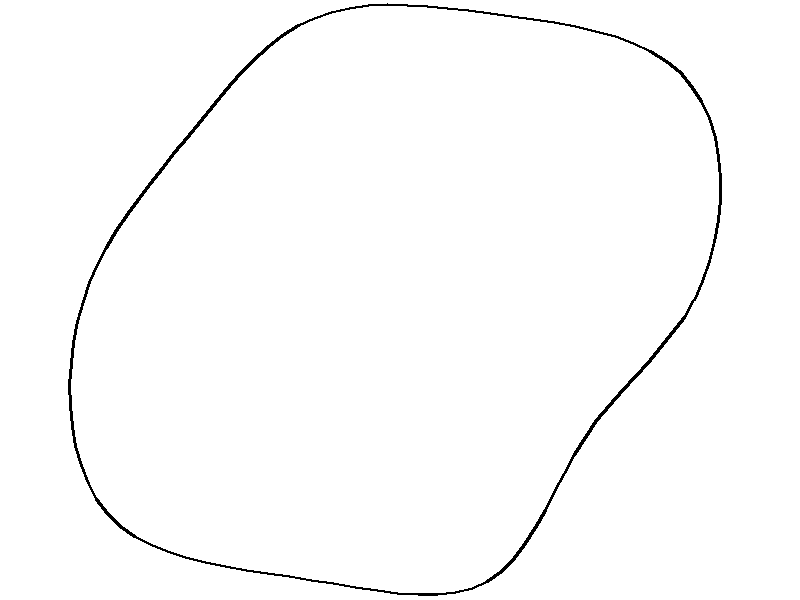

In [6]:
from PIL import Image, ImageDraw
import numpy as np
from scipy.interpolate import splprep, splev

def generate_random_closed_curve_image(width, height, num_points=10, line_thickness=10, offset_range=1):
    # Generate random control points
    center_x, center_y = width // 2, height // 2
    radius = min(center_x, center_y) - line_thickness * 2
    angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
    random_offsets = np.random.uniform(-offset_range, offset_range, num_points)
    
    points = []
    for i, angle in enumerate(angles):
        for _ in range(100):  # Set maximum number of attempts
            r_offset = random_offsets[i] * radius / 4
            new_x = center_x + (radius + r_offset) * np.cos(angle)
            new_y = center_y + (radius + r_offset) * np.sin(angle)
            if line_thickness <= new_x <= width - line_thickness and line_thickness <= new_y <= height - line_thickness:
                points.append((new_x, new_y))
                break
        else:
            # If generating control points fails, add a default safe point
            new_x = center_x + radius * np.cos(angle)
            new_y = center_y + radius * np.sin(angle)
            points.append((new_x, new_y))
    
    # Fix the start position
    fixed_start_point = (center_x + radius * np.cos(0), center_y + radius * np.sin(0))
    points[0] = fixed_start_point
    
    # Add the first point at the end to close the curve
    points.append(points[0])
    
    # Smooth the control points
    points = np.array(points)
    tck, u = splprep(points.T, s=0, per=True)
    u_new = np.linspace(u.min(), u.max(), num_points * 10)
    smooth_points = splev(u_new, tck)
    
    # Create the image
    image = Image.new('RGB', (width, height), 'white')
    draw = ImageDraw.Draw(image)
    
    # Draw the smoothed curve
    smooth_points = list(zip(smooth_points[0], smooth_points[1]))
    draw.line(smooth_points, fill='black', width=line_thickness)
    
    return image

# Specify the size and thickness of the line
width, height, line_thickness = 800, 600, 3
offset_range = 1.0  # Adjust the range of offsets
image = generate_random_closed_curve_image(width, height, num_points=10, line_thickness=line_thickness, offset_range=offset_range)

# Save the image
image.save('../texture/random_line_trace_ground.png')

# Display the image
image.show()
